# Initialize experiment, convert eugene's QASM to Scaffold

In [31]:
import sys
sys.path.append('/usr/local/xacc/lib/python')
import numpy as np
import matplotlib.pyplot as plt
import operator
from functools import reduce 
import pyxacc as xacc
%matplotlib inline

xacc.Initialize()

file = open('supremacy_test.hpp', 'r')
src = file.read()

lines = src.split('\n')
newSrc = lines[0].replace('qreg','cbit').replace('q','c') + ';\n'
nQubits = int(lines[0].replace('qreg','').replace('q','').replace('[','').replace(']',''))
for l in lines[1:]:
    if l != '':
        if 'CNOT' in l:
            l = l.replace(',','')
            comps = l.split(' ')
            newSrc += 'CNOT('+comps[1]+', ' + comps[2] +');\n'
        else:
            comps = l.split(' ')
            gateName = comps[0]
            if gateName == 'S':
                newSrc += 'Rz('+comps[1]+', '+str(np.pi/2.)+ ');\n'
            elif gateName == 'T': 
                newSrc += 'Rz('+comps[1]+', '+str(np.pi/4.)+ ');\n'
            else:
                newSrc += gateName + '('+comps[1]+');\n'
            
for i in range(nQubits):
    newSrc += 'c['+str(i)+'] = MeasZ(q['+str(i)+']);\n'

newSrc = '__qpu__ supremacy(qbit q) {\n' + newSrc + '}\n'

# Create TNQVM and qubit buffer, run Program, get Kernel

In [2]:
qpu = xacc.getAccelerator('tnqvm')
buffer = qpu.createBuffer('q',13)

p = xacc.Program(qpu, newSrc)
p.build()

xacc.setOption('itensor-samples', '1000')

k = p.getKernels()[0]


# Run Problem, sample bit strings

In [3]:
xacc.setOption('itensor-compute-samples', '1000')
k.execute(buffer, [])

measurements = buffer.getMeasurementStrings()

0100010110101
0101010010010
1111100111101
1010010100011
1110001100100
0001100110010
1101111001111
0011010110001
0001101110111
1110001111011
1000011110111
0010111001111
1010010011101
1110010101000
0010110110000
1000111010001
1100100101111
0101010100011
1010100001001
0011001001011
1000101110001
1111011000010
0101010010010
0110000001010
0110001100010
0100010101010
0101001000011
1010000100110
1100001010100
1101101010111
1111000101011
1000011001110
1100000001011
0100111001011
0110000101100
1110110111111
0011001111100
1100000101101
1111101101010
0110011011001
0011100110000
1011001010100
1011100100111
1101001110111
0001011000110
1100100011111
0110101111111
1101101001010
0010111111110
0011001100110
0101110011000
0100100111111
0110111011111
0000101001100
0111001101101
0000100100001
1010001010001
1101000010101
1001110110110
1110011111001
1100010000010
0001110101011
0111010110000
0100010111010
1011110110101
1000010000000
1000101010100
0001110011100
0001110001011
1111001100010
1101110000110
001101

# Compute Probabilities

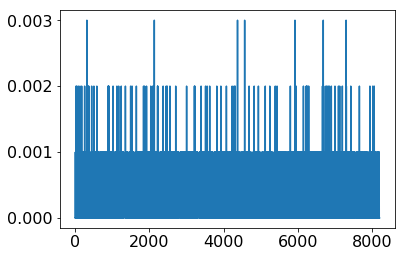

In [42]:
strings = ['{0:013b}'.format(i) for i in range(2**nQubits)]
realprobs = [buffer.computeMeasurementProbability(bitstr) for bitstr in strings]

plt.rcParams.update({'font.size': 16})
plt.plot(realprobs)

plt.show()
assert(abs(1 - sum(realprobs)) < 1e-12)

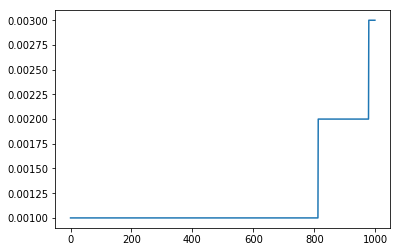

In [32]:
indexed_probz = list(zip(probs, range(2**13)))
indexed_probz.sort()
sorted_indices = [i[1] for i in indexed_probz]
plt.plot([probs[s] for s in sorted_indices], label ='no error')


In [ ]:
xacc.Finalize()